# BERT

Load and install necessary packages:

In [1]:
from google.colab import drive
import numpy as np
drive.mount('/content/drive/')

import pandas as pd
!pip install ktrain
import ktrain
from ktrain import text

Mounted at /content/drive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 50.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 61.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.4/265.4 KB 25.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 112.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 KB 47.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (

Read the preprocessed data in:

In [2]:
cleaned_data = pd.read_csv('/content/drive/MyDrive/yahoo_train.csv')
topic_labels = cleaned_data[['topic', 'topic_name']].drop_duplicates()
cleaned_data = cleaned_data[cleaned_data.topic.isin([0,1,2])].sample(100000).reset_index(drop=True)[['topic', 'text_clean']]

# BERT Model using ktrain

In [3]:
# 2. Create train, validation & preprocessing datasets using texts_from_df in ktrain
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=cleaned_data,
                                                                  text_column='text_clean',
                                                                  label_columns='topic',
                                                                  maxlen=64,
                                                                  val_pct=.3,
                                                                  preprocess_mode='bert')

# 3. Create and Train the BERT Model
model = text.text_classifier(name='bert',
                             train_data=(X_train, y_train),
                             preproc=preproc,
                             multilabel=True) 

# 4. Setting up learner
learner = ktrain.get_learner(model=model,
                             train_data=(X_train, y_train),
                             val_data=(X_test, y_test),
                             batch_size=64)

# 5. Fitting model using one-cycle poliy, lr=2e-5 from research paper
learner.fit_onecycle(lr=2e-5, epochs=3); 
     
# 6. Get predictor using preproc dataset
predictor = ktrain.get_predictor(learner.model, preproc)   
     
classes = predictor.get_classes()  
classes

['topic_0', 'topic_1', 'topic_2']
       topic_0  topic_1  topic_2
25656      0.0      1.0      0.0
54642      0.0      1.0      0.0
39988      0.0      0.0      1.0
44822      1.0      0.0      0.0
4855       0.0      0.0      1.0
['topic_0', 'topic_1', 'topic_2']
       topic_0  topic_1  topic_2
92946      0.0      1.0      0.0
89195      1.0      0.0      0.0
78851      1.0      0.0      0.0
84768      0.0      1.0      0.0
47492      1.0      0.0      0.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[█████████████████.................................]

KeyboardInterrupt: ignored

Now that we've fitted our model, we can predict the test set and assess the performance of our model

In [ ]:
predictions = learner.model.predict(X_test)
class_predictions = np.argmax(predictions, axis=1)
y_class = np.argmax(y_test, axis=1)

array([[4.6023380e-02, 9.5233226e-01, 9.0094805e-03],
       [9.7502202e-01, 9.5482310e-03, 1.1223157e-02],
       [2.4972005e-02, 9.6956015e-01, 2.3645319e-03],
       ...,
       [3.8061517e-01, 3.6410716e-01, 1.5037602e-01],
       [9.9849224e-01, 1.9386645e-03, 9.1922254e-04],
       [2.0222745e-03, 2.8279493e-02, 9.6904880e-01]], dtype=float32)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score

precision, recall, fscore, support = score(y_class, class_predictions)

print('Avg precision: {}'.format(precision.mean()))
print('Avg recall: {}'.format(recall.mean()))
print('Avg fscore: {}'.format(fscore.mean()))
print('support: {}'.format(support))

print('Avg accuracy: {}'.format(accuracy_score(y_class, class_predictions)))

Avg precision: 0.8960835003463217
Avg recall: 0.8958970820020138
Avg fscore: 0.8958863355448555
support: [10039 10071  9890]
Avg accuracy: 0.8958666666666667


Heatmap of classification

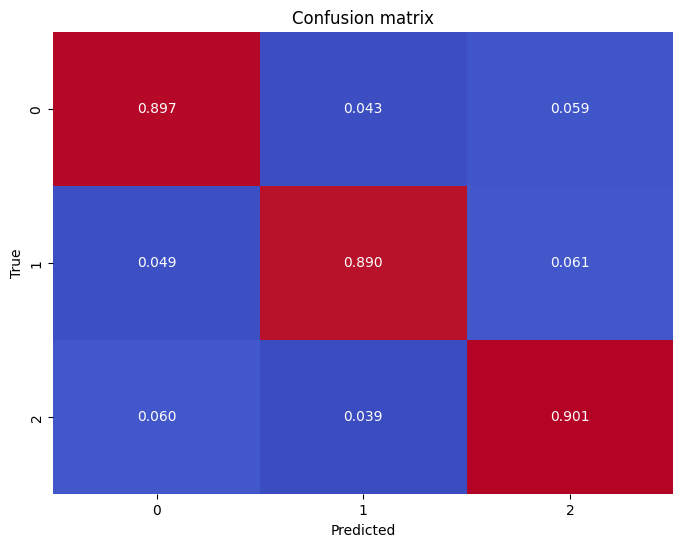

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_predicted):
    cm = confusion_matrix(y_test, y_predicted)
    cm_proportions = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_proportions, annot=True, cmap='coolwarm', fmt='.3f', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion matrix')
    plt.show()

plot_confusion_matrix(y_class, class_predictions)

# Test prompts
Let's test the model by providing it some test prompts and see what it predicts.

In [ ]:
topics = topic_labels[topic_labels.topic.isin([0,1,2])].sort_values('topic').reset_index(drop=True)


,topic,topic_name
0,0,Society & Culture
1,1,Science & Mathematics
2,2,Health


In [ ]:
a_question = "my head hurts, should I see a doctor?"
another_question = "who do you think will win the best actor at the oscars this year?"
final_question = "If you wish to make an apple pie from scratch, you must first invent the universe"

my head hurts, should I see a doctor?
[('topic_0', 0.01770344), ('topic_1', 0.022975363), ('topic_2', 0.96985406)]
most likely topic: Health
who do you think will win the best actor at the oscars this year?
[('topic_0', 0.9123698), ('topic_1', 0.10343975), ('topic_2', 0.014000283)]
most likely topic: Society & Culture
If you wish to make an apple pie from scratch, you must first invent the universe
[('topic_0', 0.107348755), ('topic_1', 0.8772431), ('topic_2', 0.008619145)]
most likely topic: Science & Mathematics


,topic,topic_name
0,0,Society & Culture
1,1,Science & Mathematics
2,2,Health


In [ ]:
example_predictions = predictor.predict([a_question,another_question,final_question])
# Convert list of tuples to dictionary
dict_output = [{t[0]: t[1] for t in row} for row in example_predictions]

# Create DataFrame from dictionary
output_df = pd.DataFrame(dict_output).set_axis([a_question,another_question,final_question], axis=0).rename(columns={'topic_0': 'Society & Culture', 'topic_1': 'Science & Mathematics', 'topic_2': 'Health'})
output_df['Highest Probability'] = output_df.apply(lambda x: topics.topic_name[np.argmax(x)], axis=1)

In [ ]:
output_df

,Society & Culture,Science & Mathematics,Health,Highest Probability
"my head hurts, should I see a doctor?",0.017703,0.022975,0.969854,Health
who do you think will win the best actor at the oscars this year?,0.912370,0.103440,0.014000,Society & Culture
"If you wish to make an apple pie from scratch, you must first invent the universe",0.107349,0.877243,0.008619,Science & Mathematics


# Error Correction
What happens when we train on 1.5 times the data?

In [4]:
cleaned_data = pd.read_csv('/content/drive/MyDrive/yahoo_train.csv')
topic_labels = cleaned_data[['topic', 'topic_name']].drop_duplicates()
cleaned_data = cleaned_data[cleaned_data.topic.isin([0,1,2])].sample(150000).reset_index(drop=True)[['topic', 'text_clean']]

In [5]:
# 2. Create train, validation & preprocessing datasets using texts_from_df in ktrain
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=cleaned_data,
                                                                  text_column='text_clean',
                                                                  label_columns='topic',
                                                                  maxlen=64,
                                                                  val_pct=.3,
                                                                  preprocess_mode='bert')

# 3. Create and Train the BERT Model
model = text.text_classifier(name='bert',
                             train_data=(X_train, y_train),
                             preproc=preproc,
                             multilabel=True) 

# 4. Setting up learner
learner = ktrain.get_learner(model=model,
                             train_data=(X_train, y_train),
                             val_data=(X_test, y_test),
                             batch_size=64)

# 5. Fitting model using one-cycle poliy, lr=2e-5 from research paper
learner.fit_onecycle(lr=2e-5, epochs=3); 
     
# 6. Get predictor using preproc dataset
predictor = ktrain.get_predictor(learner.model, preproc)   
     
classes = predictor.get_classes()  
classes

['topic_0', 'topic_1', 'topic_2']
        topic_0  topic_1  topic_2
43780       0.0      0.0      1.0
36754       1.0      0.0      0.0
148653      0.0      0.0      1.0
80300       1.0      0.0      0.0
112047      0.0      0.0      1.0
['topic_0', 'topic_1', 'topic_2']
        topic_0  topic_1  topic_2
32077       1.0      0.0      0.0
23804       0.0      1.0      0.0
147834      0.0      1.0      0.0
91241       0.0      1.0      0.0
95501       1.0      0.0      0.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? True
maxlen is 64


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
1641/1641 [==============================] - 1598s 959ms/step - loss: 0.2429 - accuracy: 0.8513 - val_loss: 0.1818 - val_accuracy: 0.8950
Epoch 2/3
1641/1641 [==============================] - 1573s 959ms/step - loss: 0.1690 - accuracy: 0.9019 - val_loss: 0.1746 - val_accuracy: 0.8975
Epoch 3/3
1641/1641 [==============================] - 1574s 959ms/step - loss: 0.1193 - accuracy: 0.9341 - val_loss: 0.1845 - val_accuracy: 0.8971


['topic_0', 'topic_1', 'topic_2']

In [6]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score

predictions = learner.model.predict(X_test)
class_predictions = np.argmax(predictions, axis=1)
y_class = np.argmax(y_test, axis=1)



precision, recall, fscore, support = score(y_class, class_predictions)

print('Avg precision: {}'.format(precision.mean()))
print('Avg recall: {}'.format(recall.mean()))
print('Avg fscore: {}'.format(fscore.mean()))
print('support: {}'.format(support))

print('Avg accuracy: {}'.format(accuracy_score(y_class, class_predictions)))

1407/1407 [==============================] - 207s 142ms/step
Avg precision: 0.8973257309389565
Avg recall: 0.8970532506373846
Avg fscore: 0.8970965579131582
support: [15084 14986 14930]
Avg accuracy: 0.8970666666666667
